<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/Unfolded_VQC_with_Learnable_SPSA_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512544 sha256=afaab5555492ef4ba82710c67f6f6e344ded1aa063ea33b228e180812eb66010
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d5

In [3]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [5]:

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
    def save_to_csv(self, filename='optimizer_log_default.csv'):
        """Save evaluations and costs to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost'])
            for evaluation, cost in zip(self.evaluations, self.costs):
                writer.writerow([evaluation, cost])
        print(f"Optimizer log saved to {filename}")

Epoch 1, Cost: 0.9904499504281535
Epoch 2, Cost: 0.985137008694658
Epoch 3, Cost: 0.9825330489716144
Epoch 4, Cost: 0.9680857853936187
Epoch 5, Cost: 0.9895143247608968
Epoch 6, Cost: 0.986525189742945
Epoch 7, Cost: 0.9900290580803672
Epoch 8, Cost: 1.0010061400198702
Epoch 9, Cost: 0.9733116151319454
Epoch 10, Cost: 0.9830495920797745
Epoch 11, Cost: 0.9947745253694908
Epoch 12, Cost: 0.9821935796213129
Epoch 13, Cost: 0.9822841071754367
Epoch 14, Cost: 0.9861664280970078
Epoch 15, Cost: 0.9991809098238906
Epoch 16, Cost: 0.9993788337542562
Epoch 17, Cost: 0.9752597348829284
Epoch 18, Cost: 1.0281198363683415
Epoch 19, Cost: 0.9977487469537392
Epoch 20, Cost: 1.0094504397255313
Epoch 21, Cost: 0.9927980141973298
Epoch 22, Cost: 1.0022665107301647
Epoch 23, Cost: 0.9859266247645637
Epoch 24, Cost: 1.0012996974387218
Epoch 25, Cost: 1.0083075722811352
Epoch 26, Cost: 0.9670693768514711
Epoch 27, Cost: 0.9736964099207833
Epoch 28, Cost: 0.9851003158953319
Epoch 29, Cost: 1.0028890974877

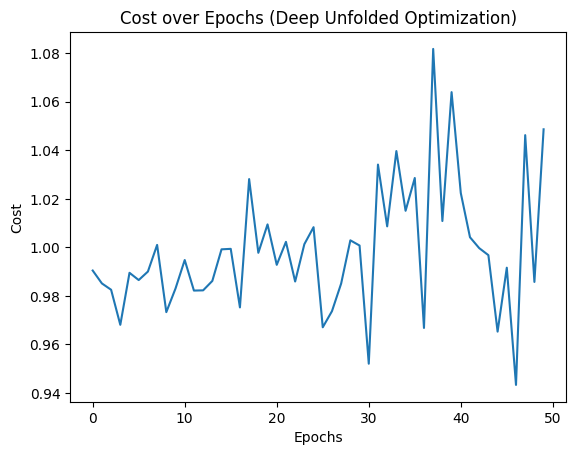

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit import transpile

# Define the deep unfolded optimization
class DeepUnfoldedOptimization:
    def __init__(self, num_layers, learning_rates):
        self.num_layers = num_layers
        self.learning_rates = learning_rates  # Learnable learning rates for each layer

    def spsa_step(self, variational, data, labels):
        delta = np.random.choice([-1, 1], size=len(variational))
        loss_plus = cost_function(data, labels, variational + delta)
        loss_minus = cost_function(data, labels, variational - delta)
        gradient = (loss_plus - loss_minus) / (2 * delta)
        return gradient

    def forward(self, variational, data, labels):
        """Unroll the optimization process over a fixed number of layers."""
        for layer in range(self.num_layers):
            gradient = self.spsa_step(variational, data, labels)
            variational = variational - self.learning_rates[layer] * gradient
        return variational

    def train(self, variational, data, labels, num_epochs, learning_rate_lr=0.01):
        """Train the learnable parameters (learning rates)"""
        log = OptimizerLog()
        for epoch in range(num_epochs):
            opt_variational = self.forward(variational, data, labels)
            cost = cost_function(data, labels, opt_variational)

            # Update the learning rates (gradient descent on learning rates)
            for layer in range(self.num_layers):
                gradient = self.spsa_step(variational, data, labels)
                self.learning_rates[layer] -= learning_rate_lr * np.dot(gradient, gradient)

            log.update(epoch, variational, cost, 0, 0)  # Update log
            print(f"Epoch {epoch+1}, Cost: {cost}")

        return log

# Set up initial parameters
initial_variational = np.array([3.28559355, 5.48514978, 5.13099949,
                                0.88372228, 4.08885928, 2.45568528,
                                4.92364593, 5.59032015, 3.66837805,
                                4.84632313, 3.60713748, 2.43546])

# Define number of layers and learning rates for each layer
num_layers = 10
initial_learning_rates = np.ones(num_layers) * 0.01

# Initialize Deep Unfolding Model
deep_unfolded_model = DeepUnfoldedOptimization(num_layers, initial_learning_rates)

# Train the model
log = deep_unfolded_model.train(initial_variational, TRAIN_DATA, TRAIN_LABELS, num_epochs=50)

# Plot the cost over epochs
plt.plot(log.evaluations, log.costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost over Epochs (Deep Unfolded Optimization)')
plt.show()
